# Ev Fiyatı Tahmin Etme Modeli Oluşturma

Kullanılan kütüphaneler
- pandas ve numpy, vektörizasyon işlemleriyle hız kazanmak için kullanılmıştır
- matplotlib.pyplot ve seaborn, grafik çizimlerinde kullanılmıştır

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Fonksiyonlar

In [2]:
def standardization(df):
  """
    Bu fonksiyon dataframe yapısını standardize eder.
    Girdiler:
      df (pd.DataFrame) : Verilerin bulunduğu dataframe yapısı
    Çıktılar:
      df_std (pd.DataFrame) : Verilen kendi sütunlarına göre standardize edilmiş hali
      mean_all (list) : Her sütunun ortalama değeri
      std_all (list) : Her sütunun standart sapma değeri 
  """
  df_std = pd.DataFrame()
  mean_all = []
  std_all = []
  
  for column in df.columns:
    mean = df[column].mean()
    mean_all.append(mean)
    std = df[column].std()
    std_all.append(std)
    df_std[column] = (df[column] - mean) / std
    
  return df_std, mean_all, std_all

In [3]:
def shuffleAndSplitData(df, test_ratio):
  """
    Bu fonksiyon dataframe yapısındaki veri sırasını karıştırır ve verilen orana göre
    datayı test ve veri olarak böler. Ardından test ve train içerisinden özellikleri (X)
    ve labelları (y) ayırır. Ayrıca geri dönüşte labellar için reshape işlemi yapılmıştır
    ki modelde kullanımı olabilsin.
    Girdiler:
      df (pd.DataFrame) : Verilerin bulunduğu dataframe yapısı
      test_ratio (float) : Test verilerinin genel veriye olması gereken oranı
    Çıktılar:
      X_train (np.array) : Eğitimde kullanılacak verilerin özellikleri
      y_train (np.array) : Eğitimde kullanılacak verilerin hedef fiyatları
      X_test (np.array) : Test için ayrılan verilerin özellikleri
      y_test (np.array) : Test için ayrılan verilerin hedef fiyatları
  """

  shuffled_df = df.sample(frac=1).reset_index(drop=True)

  test_size = int(len(shuffled_df) * test_ratio)

  train_df = shuffled_df.iloc[:-test_size]
  test_df = shuffled_df.iloc[-test_size:]

  X_train = train_df.drop("Fiyat (TL)", axis=1).to_numpy()
  y_train = train_df["Fiyat (TL)"].to_numpy()

  X_test = test_df.drop("Fiyat (TL)", axis=1).to_numpy()
  y_test = test_df["Fiyat (TL)"].to_numpy()
    
  return X_train, y_train.reshape((len(y_train), 1)), X_test, y_test.reshape((len(y_test), 1))

In [4]:
def computeCost(X,y,W,b):
    """
    Bu fonksiyon girdilere göre fiyatı tahmin eder ve MSE (Mean Squared Error) hesabını
    kullanarak bir hata yüzdesi hesaplar.
    Girdiler:
      X (np.array) : Verilerin özelliklerini bulunduran array
      y (np.array) : Verilerin hedef fiyatlarını bulunduran array
      W (np.array) : Özelliklerin kat sayılarının bulunduğu array
      b (float) : Fonksiyonun sabit değeri :)
    Çıktılar:
      J (float) : Hesaplanan yüzdesel hata
  """
    m=len(y)
    y_pred = X.dot(W) + b
    J = np.sum((y_pred - y)**2) / (2*m)
    
    return J

In [5]:
def gradientDescent(X, y, W, b, alpha, num_iters):
    """
    Bu fonksiyon gradient descent yaklaşımıyla W ve b parametrelerini optimize eder.
    Girdiler:
      X (np.array) : Verilerin özelliklerini bulunduran array
      y (np.array) : Verilerin hedef fiyatlarını bulunduran array
      W (np.array) : Özelliklerin kat sayılarının bulunduğu array
      b (float) : Fonksiyonun sabit değeri
      alpha (float) : Öğrenme katsayısı
      num_iters (int) : İterasyon sayısı
    Çıktılar:
      W (np.array) : Özelliklerin kat sayılarının bulunduğu array
      b (float) : Fonksiyonun sabit değeri
      J_history (list) : Tüm iterasyonların hesaplanan cost değeri
  """
    (m, n) = X.shape
    J_history=[]

    for i in range(num_iters):
        y_pred = X.dot(W) + b

        dJ_b = np.sum(y_pred - y) / m
        dJ_W = np.dot(X.T, (y_pred - y)) / m

        W = W - np.dot(alpha, dJ_W)
        b = b - np.dot(alpha, dJ_b)
        J_history.append(computeCost(X,y,W,b))
    
    return W, b, J_history

In [6]:
def train(df, alpha, num_iters, epoch):
  """
    Bu fonksiyon dataframe yapısını standardize eder.
    Girdiler:
      df (pd.DataFrame) : Verilerin bulunduğu dataframe yapısı
      alpha (float) : Öğrenme katsayısı
      num_iters (int) : İterasyon sayısı
      epoch (int) : Datasetinin kaç kez karıştırılıp kullanılacağını belirten sayı
    Çıktılar:
      W (np.array) : Özelliklerin kat sayılarının bulunduğu array
      b (float) : Fonksiyonun sabit değeri
      J_history_epoch (nested list) : Tüm epochlara ait tüm iterasyonların hesaplanan cost değeri
      test_cost (list) : Modelin her epoch sonu test kümesindeki hata yüzdesi
  """
  X_train, y_train, X_test, y_test = shuffleAndSplitData(df, 0.2)
  (m, n) = X_train.shape
  W = np.zeros((n,1))
  b = 0
  J_history_epoch = []
  test_cost = []

  for i in range(epoch):
    W, b, J_history = gradientDescent(X_train, y_train, W, b, alpha, num_iters)
    test_cost.append(computeCost(X_test, y_test, W, b))
    J_history_epoch.append(J_history)
    X_train, y_train, X_test, y_test = shuffleAndSplitData(df, 0.2)

  return W, b, J_history_epoch, test_cost

Veriyi okuma

In [7]:
data = pd.read_csv("sahibinden_satilik_daire_df.csv")

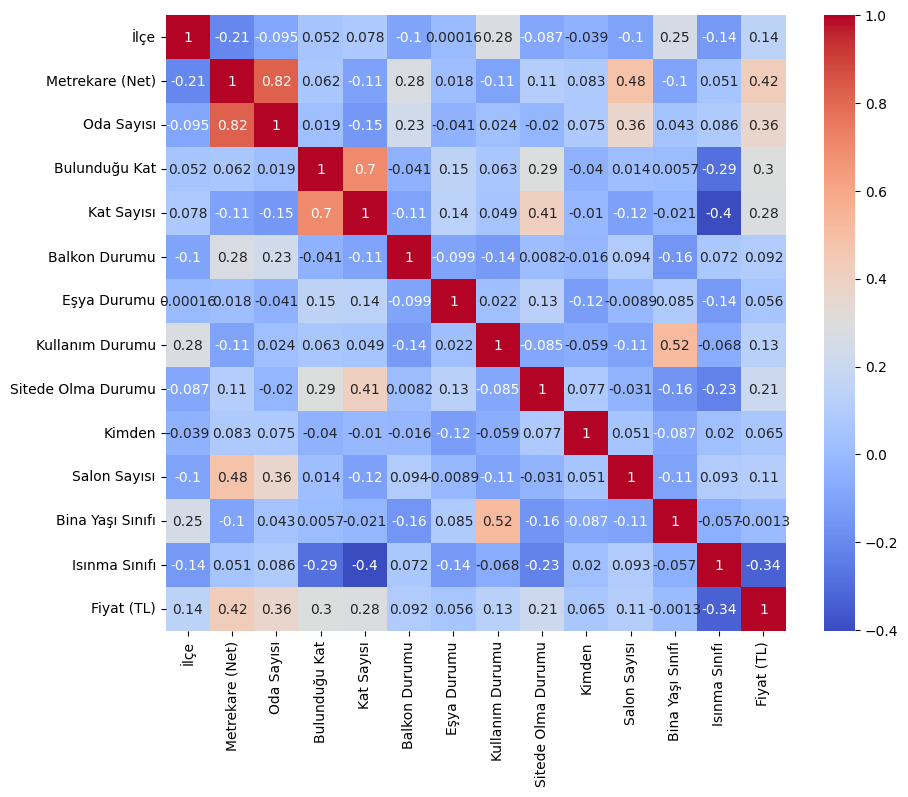

In [8]:
correlationMatrix = data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlationMatrix, annot=True, cmap='coolwarm')
plt.show()

In [9]:
sortedPriceCorelationValues = correlationMatrix[['Fiyat (TL)']].abs().sort_values(by='Fiyat (TL)', ascending=False)
sortedPriceCorelationValues

,Fiyat (TL)
Fiyat (TL),1.000000
Metrekare (Net),0.423522
Oda Sayısı,0.364276
Isınma Sınıfı,0.336078
Bulunduğu Kat,0.295243
Kat Sayısı,0.282757
Sitede Olma Durumu,0.208395
İlçe,0.143125
Kullanım Durumu,0.126407
Salon Sayısı,0.111274


Korelasyon sonucu raporda da açıkladığımız gibi bir özellik eleme yapmamaya karar verdik. PCA işlemininse kullanıcıdan veri alıp tahmin yaparken sıkıntı çıkaracağını düşündüğümüz için PCA işlemi de yapmamaya karar verdik

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
İlçe,504.0,7.073413e+00,5.067395e+00,0.0,3.0,5.0,10.0,18.0
Metrekare (Net),504.0,1.086290e+02,4.045009e+01,29.0,85.0,100.0,125.0,370.0
Oda Sayısı,504.0,2.393849e+00,8.100646e-01,1.0,2.0,2.0,3.0,5.0
Bulunduğu Kat,504.0,3.301587e+00,3.328938e+00,-3.0,1.0,2.0,4.0,22.0
Kat Sayısı,504.0,6.898810e+00,4.633665e+00,1.0,4.0,5.0,8.0,27.0
Balkon Durumu,504.0,8.174603e-01,3.866725e-01,0.0,1.0,1.0,1.0,1.0
Eşya Durumu,504.0,5.158730e-02,2.214121e-01,0.0,0.0,0.0,0.0,1.0
Kullanım Durumu,504.0,5.734127e-01,8.356897e-01,0.0,0.0,0.0,1.0,2.0
Sitede Olma Durumu,504.0,4.107143e-01,4.924523e-01,0.0,0.0,0.0,1.0,1.0
Kimden,504.0,1.924603e+00,2.928401e-01,0.0,2.0,2.0,2.0,2.0


Preprocessing -> Standartlaştırma

In [11]:
df_std, means, stds = standardization(data)

Modelin Eğitimi

Modelin eğitiminde hiperparametrelerin değerleri:
- learning rate : 0.01,
- iterasyon sayısı : 500,
- epoch : 50,
olarak ayarlanmıştır.

In [98]:
W, b, J_history, test_cost = train(df_std, 0.01, 500, 50)

Model Çıktılarının Değerlendirmesi

In [99]:
epoch_end_cost = [J_history[i][-1] for i in range(len(J_history))]

Text(0.5, 1.0, 'Cost End Of Epoch')

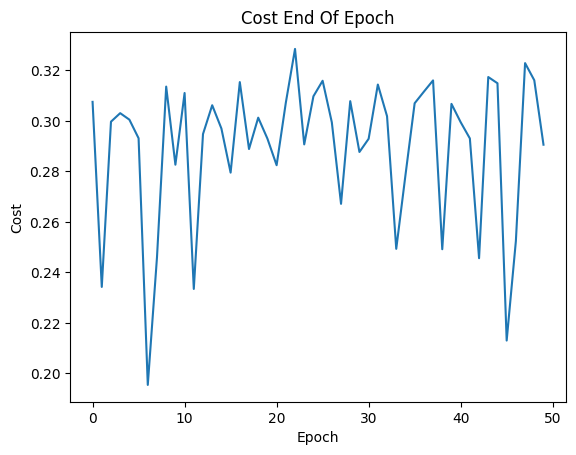

In [100]:
plt.plot(epoch_end_cost)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Cost End Of Epoch")

Text(0.5, 1.0, 'Test Cost End Of Epoch')

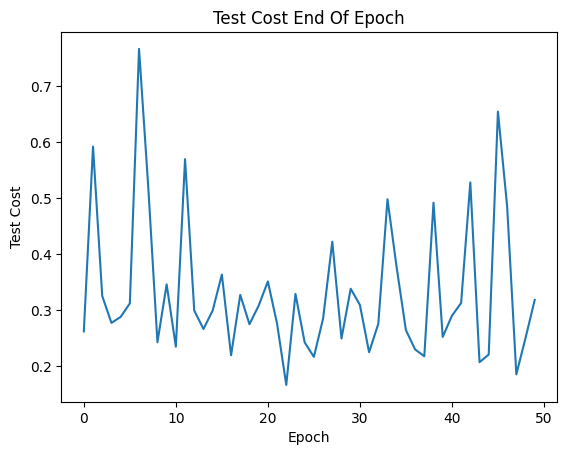

In [101]:
plt.plot(test_cost)
plt.xlabel("Epoch")
plt.ylabel("Test Cost")
plt.title("Test Cost End Of Epoch")

Yüzdesel olarak son hata oranları

In [102]:
J_history[-1][-1]   #train

0.2905804556650093

In [103]:
test_cost[-1]       #test

0.317919864394371

Kullanıcının girdileriyle tahmin yapabilmek için kaydettiğimiz parametreler

In [104]:
means

[7.073412698412699,
 108.62896825396825,
 2.3938492063492065,
 3.3015873015873014,
 6.898809523809524,
 0.8174603174603174,
 0.051587301587301584,
 0.5734126984126984,
 0.4107142857142857,
 1.9246031746031746,
 1.0476190476190477,
 3.492063492063492,
 5.690476190476191,
 4114137.003968254]

In [105]:
stds

[5.0673954336946,
 40.45009238903289,
 0.810064588323567,
 3.3289377436818497,
 4.633665228598655,
 0.3866724774069063,
 0.2214121053490296,
 0.8356896536003376,
 0.4924522619831205,
 0.2928400748076689,
 0.23952049040186854,
 3.2855997192061337,
 0.7510288314006336,
 4902136.518217785]

In [114]:
W.tolist()

[[0.19885991272982728],
 [0.5022411180118004],
 [0.04620855828915394],
 [0.04253900096512786],
 [0.19494420900889392],
 [0.03243333130414767],
 [0.016219027105690217],
 [0.1655341215529108],
 [0.0026112194190809],
 [0.06530386292345758],
 [-0.07707602777134191],
 [-0.10192696439395153],
 [-0.23386847070442832]]

In [107]:
b

0.005469767801705558

In [119]:
with open('params.txt', 'w') as file:
    for item in means:
        file.write("," + str(item))
    file.write("\n")
    for item in stds:
        file.write("," + str(item))
    file.write("\n")
    for item in W.tolist():
        file.write("," + str(item[0]))
    file.write("\n")
    file.write(str(b))